**Name:** Sujan Dumaru  
**Course**: MSCS 634-B01: Advanced Big Data and Data Mining  
**Lab 6 Assignment**: Association Rule Mining with Apriori and FP-Growth

## Step 1: Data Preparation  
Load and clean the dataset, ensuring it is in a transaction-by-item format suitable for frequent itemset mining.

### Load the dataset  
Read the retail dataset into a Pandas DataFrame for further cleaning and transformation.

In [1]:
import pandas as pd

data_path = "Online Retail.xlsx"

# Load data from Excel
df_raw = pd.read_excel(data_path)
display(df_raw.head())
print("Loaded shape:", df_raw.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Loaded shape: (541909, 8)


### Clean the dataset  
Remove invalid entries, standardize item descriptions, and construct a one-hot encoded transaction-by-item basket for mining.

In [2]:
# Select the relevant column names for easier reference
transaction_col = "InvoiceNo"
item_col = "Description"
qty_col = "Quantity"

# Make a copy of the raw dataset so original stays intact
df = df_raw.copy()

# Ensure invoice numbers are strings (so we can filter out cancellations easily)
df[transaction_col] = df[transaction_col].astype(str)
# Remove canceled orders (invoices starting with 'C')
df = df[~df[transaction_col].str.startswith("C")]

# Convert quantity to numeric (coerce errors to NaN) and remove negative or zero quantities
df[qty_col] = pd.to_numeric(df[qty_col], errors="coerce")
df = df[df[qty_col] > 0]

# Standardize item descriptions: lowercase, stripped of leading/trailing spaces
df[item_col] = df[item_col].astype(str).str.strip().str.lower()
# Drop rows with missing invoice numbers or descriptions
df = df.dropna(subset=[transaction_col, item_col])

# Remove rows with no description
df = df[df[item_col].str.len() > 0]

# Count item frequency for plotting later
item_counts = df[item_col].value_counts()

# Create a transaction-by-item quantity table (pivot table style)
basket_qty = pd.crosstab(
    df[transaction_col],
    df[item_col],
    values=df[qty_col],
    aggfunc="sum"
).fillna(0)

# Convert to a binary basket: 1 if item purchased in transaction, else 0
basket = (basket_qty > 0).astype("uint8")
# Convert the basket DataFrame to boolean type to avoid the Deprecation Warning
basket_bool = basket.astype(bool)

print("Basket shape", basket.shape)
display(basket.head())

Basket shape (20728, 4061)


Description,*boombox ipod classic,*usb office mirror ball,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 hanging eggs hand painted,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exploratory visuals
Show frequent items and item co-occurrence to understand structure before mining.

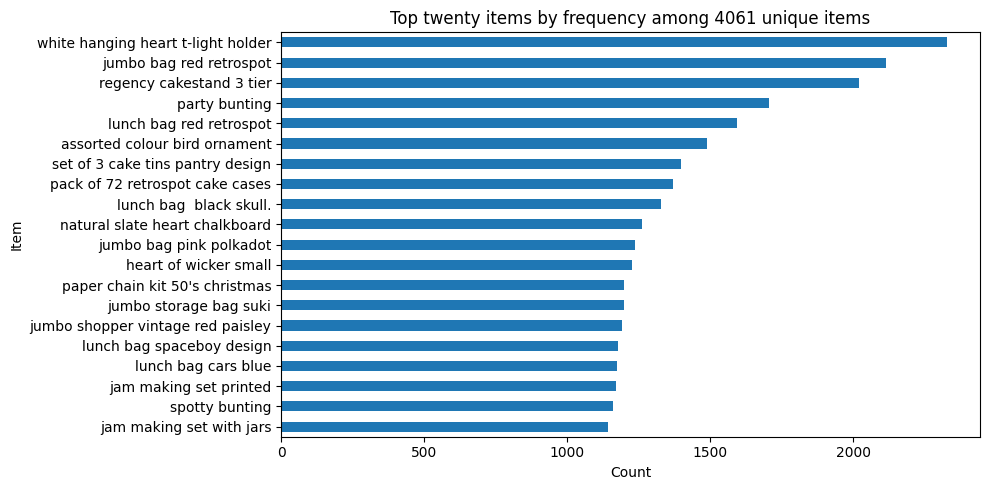

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 5))
item_counts.head(20).sort_values(ascending=True).plot(kind="barh")
plt.title(f"Top twenty items by frequency among {item_counts.shape[0]} unique items")
plt.xlabel("Count")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

**Insights:**  
The bar plot reveals that decorative home items such as "white hanging heart t-light holder" and "jumbo bag red retrospot" dominate sales volume. These products appear in significantly more transactions than others, suggesting they are key revenue drivers. Recognizing these high-frequency items can help prioritize promotional strategies and inventory stocking.

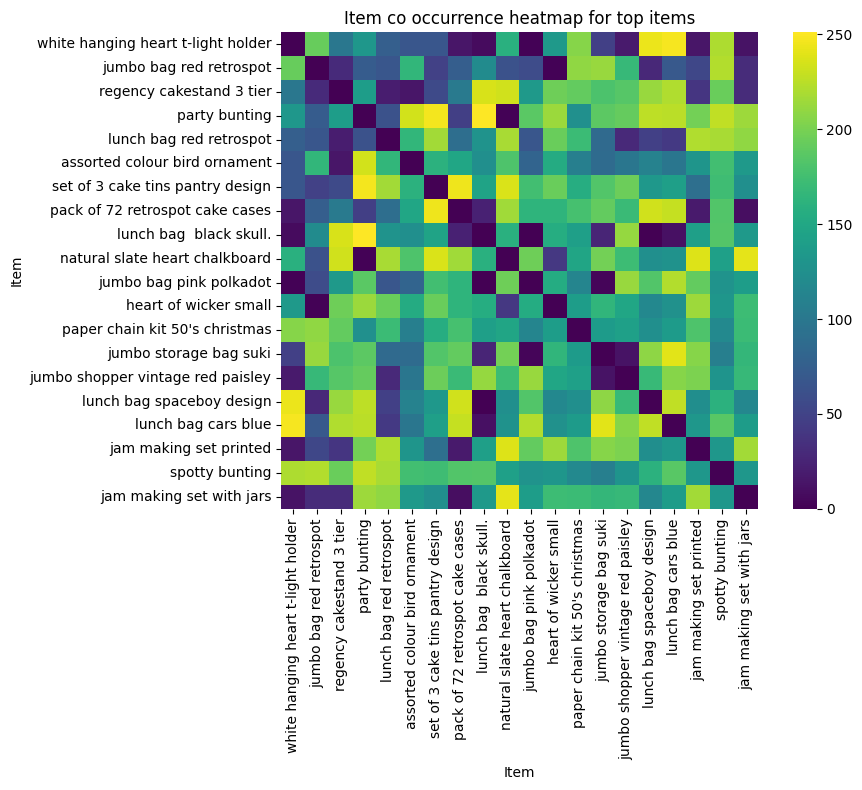

In [4]:
# Limit to top 20 items for a readable heatmap
top_n = 20
top_items = item_counts.head(top_n).index
cooc_top = basket[top_items].T.dot(basket[top_items])
np.fill_diagonal(cooc_top.values, 0.0)

plt.figure(figsize=(10, 8))
sns.heatmap(cooc_top, cmap="viridis", square=True, cbar=True)
plt.title("Item co occurrence heatmap for top items")
plt.xlabel("Item")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

**Insights:**  
The heatmap shows co-purchase relationships among the top 20 most frequently purchased items. Several strong associations stand out, such as decorative home products and seasonal items often appearing together in the same transactions. These patterns suggest potential opportunities for targeted promotions, product bundling, and inventory placement strategies.

## Step 2: Frequent Itemset Mining Using Apriori  
Apply the Apriori algorithm to find frequent itemsets based on a chosen minimum support value.

In [5]:
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from time import perf_counter

min_support = 0.02
use_colnames = True

t0 = perf_counter()
fi_ap = apriori(basket_bool, min_support=min_support, use_colnames=True, verbose=0)
apriori_time = perf_counter() - t0

fi_ap = fi_ap.sort_values("support", ascending=False).reset_index(drop=True)
print(f"Apriori runtime: {apriori_time:.4f} seconds")
print(f"Number of itemsets: {len(fi_ap)}")
display(fi_ap.head(10))

Apriori runtime: 1.7746 seconds
Number of itemsets: 348


,support,itemsets
0,0.109031,(white hanging heart t-light holder)
1,0.100926,(jumbo bag red retrospot)
2,0.095957,(regency cakestand 3 tier)
3,0.081339,(party bunting)
4,0.075453,(lunch bag red retrospot)
5,0.070195,(assorted colour bird ornament)
6,0.066818,(set of 3 cake tins pantry design)
7,0.063682,(pack of 72 retrospot cake cases)
8,0.061415,(lunch bag black skull.)
9,0.060257,(natural slate heart chalkboard)


### Visualize top frequent itemsets (Apriori)  
Plot the itemsets with the highest support values discovered by Apriori.

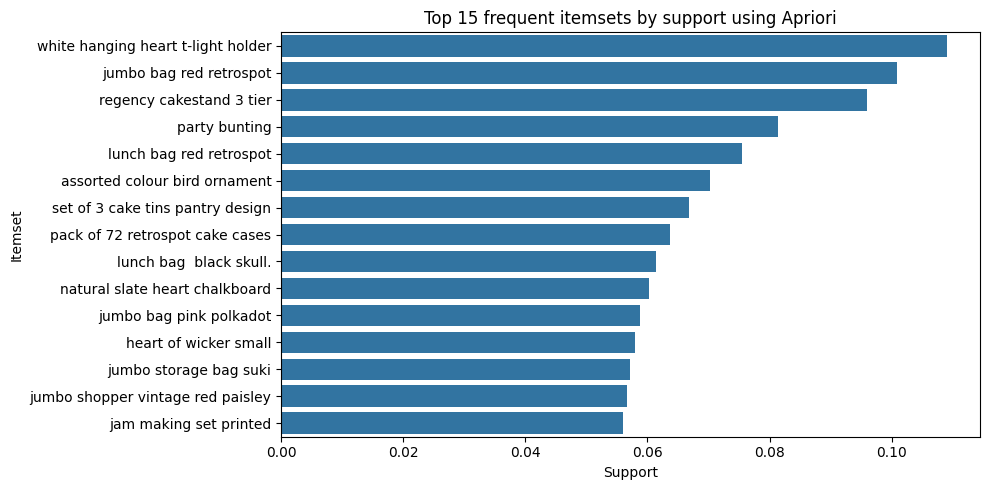

In [6]:
# Visualize the strongest itemsets by support.
def itemset_to_str(s):
    return ", ".join(sorted(list(s)))

top_k = 15
fi_ap_top = fi_ap.head(top_k).copy()
fi_ap_top["itemset_str"] = fi_ap_top["itemsets"].apply(itemset_to_str)

plt.figure(figsize=(10, 5))
sns.barplot(data=fi_ap_top, x="support", y="itemset_str")
plt.title(f"Top {top_k} frequent itemsets by support using Apriori")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

**Insights:**  
Apriori identified strong associations among popular items, with sets containing top-selling decorative and kitchen products having the highest support. This confirms that customers tend to purchase these products together, which can be leveraged for cross-selling and bundled promotions. The clear alignment with the earlier frequency analysis indicates consistency in the dataset’s underlying purchase patterns.

## Step 3: Frequent Itemset Mining Using FP-Growth  
Use the FP-Growth algorithm to find frequent itemsets with the same minimum support as Apriori for a direct comparison.

In [7]:
t0 = perf_counter()
fi_fp = fpgrowth(basket_bool, min_support=min_support, use_colnames=use_colnames, verbose=0)
fpgrowth_time = perf_counter() - t0

fi_fp = fi_fp.sort_values("support", ascending=False).reset_index(drop=True)
print(f"FP-Growth runtime: {fpgrowth_time:.4f} seconds")
print(f"Number of itemsets: {len(fi_fp)}")
display(fi_fp.head(10))

FP-Growth runtime: 6.3526 seconds
Number of itemsets: 348


,support,itemsets
0,0.109031,(white hanging heart t-light holder)
1,0.100926,(jumbo bag red retrospot)
2,0.095957,(regency cakestand 3 tier)
3,0.081339,(party bunting)
4,0.075453,(lunch bag red retrospot)
5,0.070195,(assorted colour bird ornament)
6,0.066818,(set of 3 cake tins pantry design)
7,0.063682,(pack of 72 retrospot cake cases)
8,0.061415,(lunch bag black skull.)
9,0.060257,(natural slate heart chalkboard)


### Visualize top frequent itemsets (FP-Growth)  
Plot the itemsets with the highest support values discovered by FP-Growth.

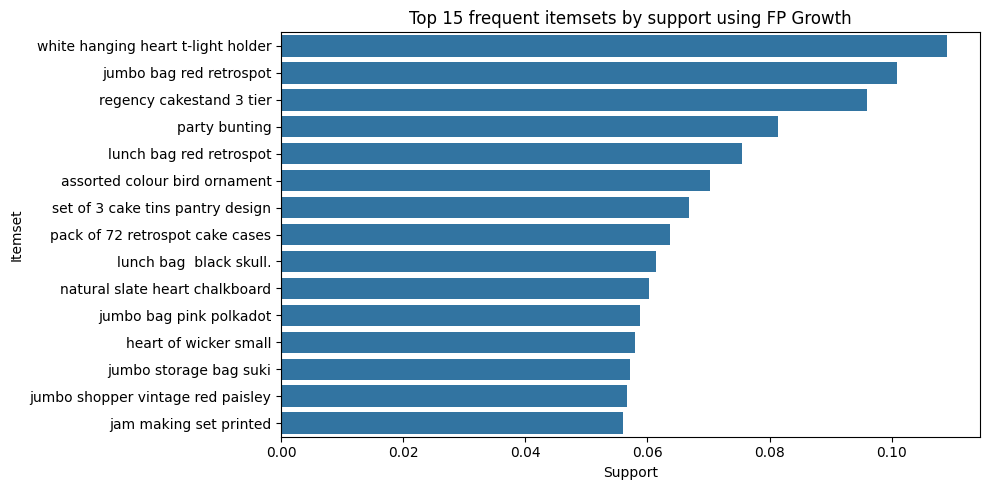

In [8]:
fi_fp_top = fi_fp.head(top_k).copy()
fi_fp_top["itemset_str"] = fi_fp_top["itemsets"].apply(itemset_to_str)

plt.figure(figsize=(10, 5))
sns.barplot(data=fi_fp_top, x="support", y="itemset_str")
plt.title(f"Top {top_k} frequent itemsets by support using FP Growth")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

**Insights:**  
FP-Growth produced itemsets similar to those from Apriori, confirming consistency in results. In this dataset, FP-Growth ran slightly slower than Apriori, likely due to the dataset’s sparsity and the overhead of constructing and traversing the FP-tree. In larger, denser datasets, FP-Growth would typically outperform Apriori in speed.

## Step 4: Association Rules
Generate association rules from the frequent itemsets using support, confidence, and lift to identify meaningful product relationships.

Rules from Apriori: 129
Rules from FP Growth: 129


,algorithm,antecedents,consequents,support,confidence,lift
0,Apriori,jumbo bag red retrospot,jumbo bag pink polkadot,0.039801,0.394359,6.711234
1,Apriori,jumbo bag pink polkadot,jumbo bag red retrospot,0.039801,0.677340,6.711234
2,Apriori,roses regency teacup and saucer,green regency teacup and saucer,0.037051,0.720450,14.712801
3,Apriori,green regency teacup and saucer,roses regency teacup and saucer,0.037051,0.756650,14.712801
4,Apriori,jumbo bag red retrospot,jumbo storage bag suki,0.034929,0.346080,6.058744


,algorithm,antecedents,consequents,support,confidence,lift
253,FP Growth,lunch bag apple design,lunch bag black skull.,0.020021,0.400579,6.522549
254,FP Growth,natural slate heart chalkboard,white hanging heart t-light holder,0.020021,0.332266,3.047436
255,FP Growth,recycling bag retrospot,jumbo bag red retrospot,0.020021,0.554813,5.497209
256,FP Growth,lunch bag pink polkadot,lunch bag suki design,0.020021,0.380734,7.273597
257,FP Growth,lunch bag suki design,lunch bag pink polkadot,0.020021,0.382488,7.273597


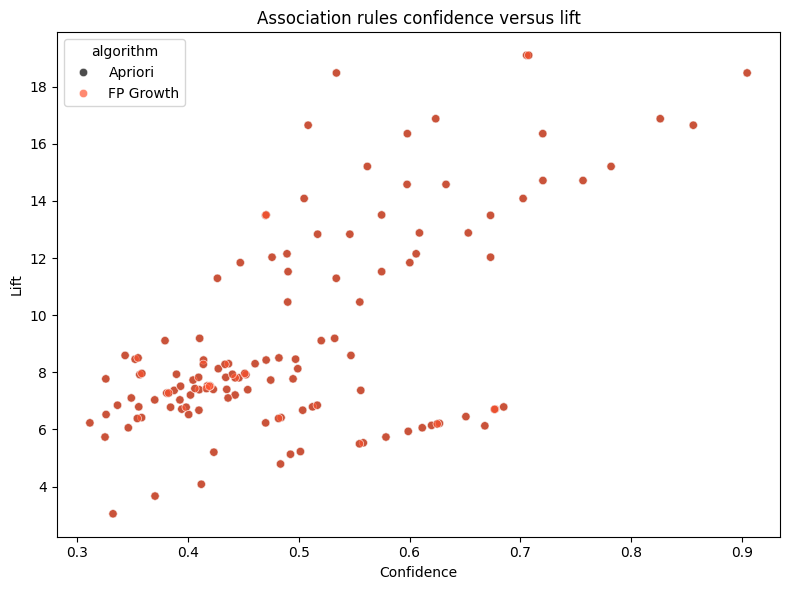

In [9]:
min_confidence = 0.30  # confidence threshold for rule generation

rules_ap = association_rules(fi_ap, metric="confidence", min_threshold=min_confidence).copy()
rules_fp = association_rules(fi_fp, metric="confidence", min_threshold=min_confidence).copy()

# tag source so we can compare in one DataFrame
rules_ap["algorithm"] = "Apriori"
rules_fp["algorithm"] = "FP Growth"

# combine for unified inspection
rules_all = pd.concat([rules_ap, rules_fp], ignore_index=True)

print("Rules from Apriori:", rules_ap.shape[0])
print("Rules from FP Growth:", rules_fp.shape[0])

rules_all_display = rules_all.copy()
rules_all_display["antecedents"] = rules_all_display["antecedents"].apply(itemset_to_str)
rules_all_display["consequents"] = rules_all_display["consequents"].apply(itemset_to_str)

display(rules_all_display.head(5)[["algorithm", "antecedents", "consequents", "support", "confidence", "lift"]])
display(rules_all_display.tail(5)[["algorithm", "antecedents", "consequents", "support", "confidence", "lift"]])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rules_all, x="confidence", y="lift", hue="algorithm", alpha=0.7, palette=["#000000", "#FF5733"])
plt.title("Association rules confidence versus lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.tight_layout()
plt.show()

**Insights:**  
The scatter plot shows several rules with high lift (>1.2) and moderate-to-high confidence, indicating strong and reliable associations between items. Rules with high lift suggest that the purchase of one item meaningfully increases the likelihood of purchasing another, which is valuable for designing targeted marketing campaigns.

### Categorize Rules based on Lift and Confidence

In [10]:
# Show top rules by lift and confidence for interpretation.
top_by_lift = rules_all_display.sort_values("lift", ascending=False).head(10)
top_by_conf = rules_all_display.sort_values("confidence", ascending=False).head(10)

print("--------------------- Top rules by lift ---------------------")
display(top_by_lift[["algorithm", "antecedents", "consequents", "support", "confidence", "lift"]])

print("--------------------- Top rules by confidence ---------------------")
display(top_by_conf[["algorithm", "antecedents", "consequents", "support", "confidence", "lift"]])

--------------------- Top rules by lift ---------------------


,algorithm,antecedents,consequents,support,confidence,lift
164,FP Growth,"green regency teacup and saucer, roses regency...",pink regency teacup and saucer,0.026148,0.705729,19.097068
165,FP Growth,pink regency teacup and saucer,"green regency teacup and saucer, roses regency...",0.026148,0.707572,19.097068
35,Apriori,"green regency teacup and saucer, roses regency...",pink regency teacup and saucer,0.026148,0.705729,19.097068
36,Apriori,pink regency teacup and saucer,"green regency teacup and saucer, roses regency...",0.026148,0.707572,19.097068
162,FP Growth,"pink regency teacup and saucer, roses regency ...",green regency teacup and saucer,0.026148,0.904841,18.478377
33,Apriori,"pink regency teacup and saucer, roses regency ...",green regency teacup and saucer,0.026148,0.904841,18.478377
167,FP Growth,green regency teacup and saucer,"pink regency teacup and saucer, roses regency ...",0.026148,0.533990,18.478377
38,Apriori,green regency teacup and saucer,"pink regency teacup and saucer, roses regency ...",0.026148,0.533990,18.478377
12,Apriori,pink regency teacup and saucer,green regency teacup and saucer,0.030538,0.826371,16.875875
141,FP Growth,pink regency teacup and saucer,green regency teacup and saucer,0.030538,0.826371,16.875875


--------------------- Top rules by confidence ---------------------


,algorithm,antecedents,consequents,support,confidence,lift
33,Apriori,"pink regency teacup and saucer, roses regency ...",green regency teacup and saucer,0.026148,0.904841,18.478377
162,FP Growth,"pink regency teacup and saucer, roses regency ...",green regency teacup and saucer,0.026148,0.904841,18.478377
34,Apriori,"green regency teacup and saucer, pink regency ...",roses regency teacup and saucer,0.026148,0.856240,16.649292
163,FP Growth,"green regency teacup and saucer, pink regency ...",roses regency teacup and saucer,0.026148,0.856240,16.649292
12,Apriori,pink regency teacup and saucer,green regency teacup and saucer,0.030538,0.826371,16.875875
141,FP Growth,pink regency teacup and saucer,green regency teacup and saucer,0.030538,0.826371,16.875875
16,Apriori,pink regency teacup and saucer,roses regency teacup and saucer,0.028898,0.781984,15.205414
145,FP Growth,pink regency teacup and saucer,roses regency teacup and saucer,0.028898,0.781984,15.205414
3,Apriori,green regency teacup and saucer,roses regency teacup and saucer,0.037051,0.756650,14.712801
132,FP Growth,green regency teacup and saucer,roses regency teacup and saucer,0.037051,0.756650,14.712801


## Step 5: Comparative Analysis  
Compare Apriori and FP-Growth in terms of runtime, output similarity, and practical implications.

,algorithm,time_seconds,num_itemsets,num_rules_at_conf
0,Apriori,1.774614,348,129
1,FP Growth,6.352646,348,129


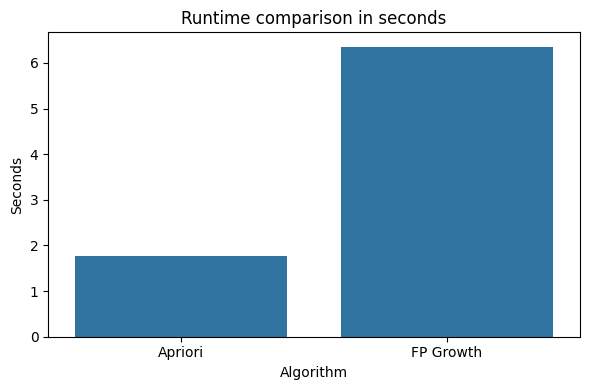

In [11]:
summary = pd.DataFrame({
    "algorithm": ["Apriori", "FP Growth"],
    "time_seconds": [apriori_time, fpgrowth_time],
    "num_itemsets": [fi_ap.shape[0], fi_fp.shape[0]],
    "num_rules_at_conf": [rules_ap.shape[0], rules_fp.shape[0]]
})
display(summary)  # tabular comparison of time and counts

plt.figure(figsize=(6, 4))
sns.barplot(data=summary, x="algorithm", y="time_seconds")
plt.title("Runtime comparison in seconds")
plt.xlabel("Algorithm")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()


**Insights:**  
On this dataset and threshold, Apriori completed faster than FP Growth. This can happen on smaller or sparser retail data where FP tree construction overhead does not amortize, while Apriori’s candidate generation and pruning remain competitive at higher supports.